In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost as xgb

In [2]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 60.6MB 1.3MB/s 


In [3]:
!pip install lightgbm --install-option=--gpu
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [0]:
# RMSLE in natural log 
def my_loss(pred, actual):
  assert len(pred) == len(actual)
  error2 = [(math.log(pred[i] + 1) - math.log(actual[i] - 1))**2 for i in range(len(pred))]
  result = np.sqrt(np.sum(error2) / len(pred))
  return result 

In [0]:
def get_loss(pred, actual):
  log_mse = mean_squared_error(np.log1p(pred), np.log1p(actual))
  result = np.sqrt(log_mse)
  return result 

## Load the data

In [0]:
# Import the all dataset
tr = pd.read_csv('train_3.csv')
te = pd.read_csv('test_3.csv')

In [0]:
# Import the all dataset
tr = pd.read_csv('train_3_svd.csv')
te = pd.read_csv('test_3_svd.csv')

In [52]:
tr.shape

(3000, 373)

In [0]:
y = tr.revenue_log
X = tr.drop('revenue_log', axis = 1)

In [0]:
# Split into train and Valid set
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size = .2, random_state = 42)

In [55]:
print("The size of the train set ", X_tr.shape)
print("The size of the validation set ", X_val.shape)
print("The size of the test set ", te.shape)

The size of the train set  (2400, 372)
The size of the validation set  (600, 372)
The size of the test set  (4398, 372)


In [0]:
del tr, X, y, 

In [0]:
df = pd.DataFrame()
df['val'] = y_val

## Validation Set

### 1. Elastic-Net

In [0]:
X_tr_el = X_tr.fillna(-1)
X_val_el = X_val.fillna(-1)
te_el = te.fillna(-1)

In [0]:
model_el = ElasticNet(alpha = .05, l1_ratio = .001, max_iter = 5000)
model_el.fit(X_tr_el, y_tr)

ElasticNet(alpha=0.05, copy_X=True, fit_intercept=True, l1_ratio=0.001,
      max_iter=5000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
pred_el = model_el.predict(X_val_el)

In [0]:
np.sqrt(mean_squared_error(y_val, pred_el))

2.0524763769667898

In [0]:
# 1st try: 2.1347
# 2nd try: 2.1266
# 3rd try: 2.0524 (Mean encoding)

In [0]:
df['el'] = pred_el

### 2. KNN 

In [0]:
# scaling?

In [0]:
model_knn = KNeighborsRegressor(n_neighbors = 30, 
                                weights = 'distance',
                                metric = 'minkowski', 
                                p = 1)  

model_knn.fit(X_tr_el, y_tr)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=30, p=1,
          weights='distance')

In [0]:
pred_knn = model_knn.predict(X_val_el)
np.sqrt(mean_squared_error(y_val, pred_knn))

2.1707756768863877

In [0]:
# 3rd try: 2.1707 (Mean encoding)

In [0]:
df['knn'] = pred_knn

### 3. Kernel SVM

In [0]:
# scaling?

In [0]:
model_svm = SVR(kernel = 'rbf')  
model_svm.fit(X_tr_el, y_tr)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
pred_svm = model_svm.predict(X_val_el)
np.sqrt(mean_squared_error(y_val, pred_knn))

2.1707756768863877

In [0]:
# 3rd try: 2.1707 (Mean encoding)

In [0]:
df['svm'] = pred_svm

### 4. Xgboost

In [0]:
model_xg = xgb.XGBRegressor(objective = 'reg:linear',
                            n_estimators = 3000, 
                            max_depth = 9, 
                            learning_rate = 0.007,
                            early_stopping_rounds = 500,
                            gamma = 1.0, 
                            #alpha = .6,
                            subsample = 0.7,   
                            colsample_bytree = 0.7, 
                            colsample_bylevel = 0.8,
                            silent = True)

In [61]:
model_xg.fit(X_tr, y_tr)
    
pred_xg = model_xg.predict(X_val)
np.sqrt(mean_squared_error(y_val, pred_xg))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


1.8439307131131533

In [0]:
# 1st try: 1.9202
# 2nd try: 1.9128
# 3nd try: 1.8978
# 4th try: 1.8791 (Mean encoding)
# 5th try: 1.8439 (+ Voting Data)

In [25]:
param_save = model_xg.get_params
param_save

<bound method XGBModel.get_params of XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.7, early_stopping_rounds=500, gamma=1.0,
       importance_type='gain', learning_rate=0.007, max_delta_step=0,
       max_depth=9, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)>

In [0]:
df['xg'] = pred_xg

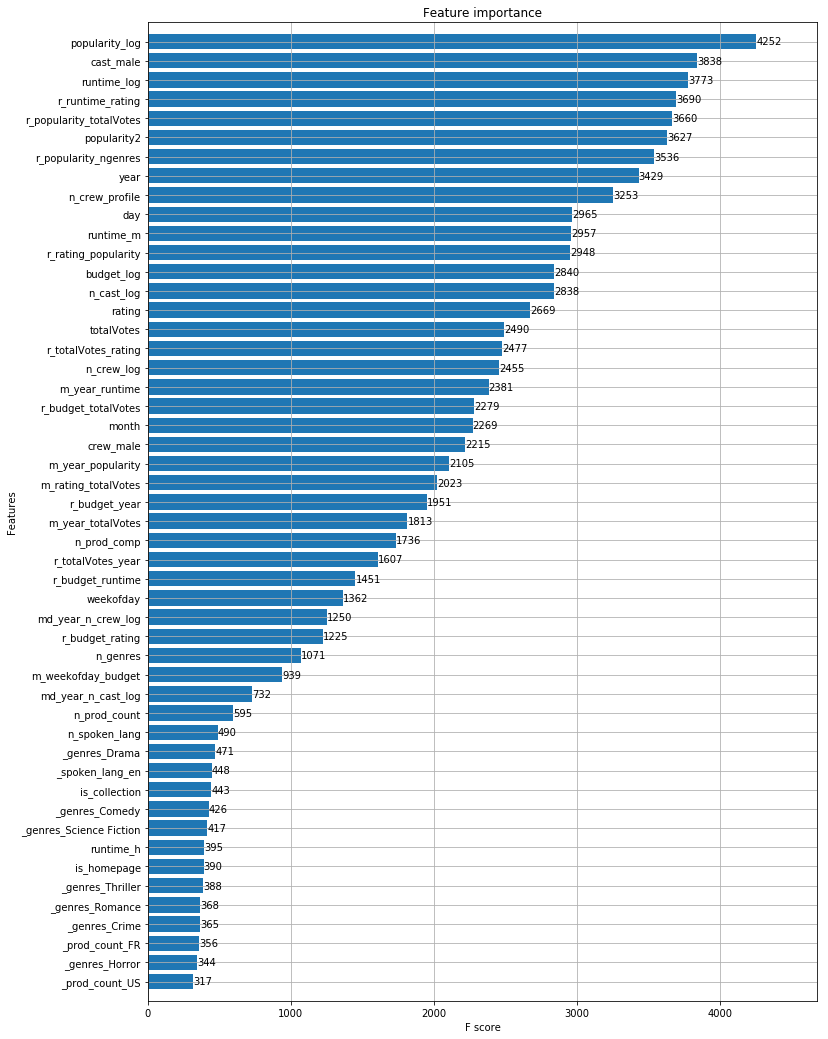

In [64]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model_xg, max_num_features= 50, height=0.8, ax=ax)
plt.show()

### 5. Catboost

In [65]:
model_cb = CatBoostRegressor(bagging_temperature = 0.5,  
                             colsample_bylevel = 0.8,  
                             depth = 9,   
                             early_stopping_rounds = 500,   
                             eval_metric = 'RMSE',
                             iterations = 3000,                             
                             learning_rate = .05,    
                             logging_level = 'Silent')

model_cb.fit(X_tr, y_tr, eval_set = (X_val, y_val), use_best_model = True)

In [66]:
pred_cb = model_cb.predict(X_val)
np.sqrt(mean_squared_error(y_val, pred_cb))

1.8268321169613426

In [0]:
# 1st try: 1.9218
# 2nd try: 1.8779
# 3rd try: 1.8753
# 4th try: 1.8618 (Mean encoding)
# 5th try: 1.8268 (+ Voting Data)

In [0]:
model_cb.get_params()

{'bagging_temperature': 0.5,
 'colsample_bylevel': 0.8,
 'depth': 9,
 'early_stopping_rounds': 500,
 'eval_metric': 'RMSE',
 'iterations': 3000,
 'learning_rate': 0.05,
 'logging_level': 'Silent',
 'loss_function': 'RMSE'}

In [0]:
df['cb'] = pred_cb

### 6. Lightgbm

In [0]:
!pip install lightgbm --install-option=--gpu
import lightgbm as lgb

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:244: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)


In [81]:
tr_data = lgb.Dataset(X_tr, label = y_tr)
val_data = lgb.Dataset(X_val, label = y_val)

params = {'objective' : 'regression',
          'num_iterations' : 10000, 
          'max_depth' : 13,
          'num_leaves' : 100,
          'learning_rate': 0.003,
          'metric' : 'rmse',
          'min_data_in_leaf' : 100,
          'colsample_bytree': 0.8,
          'subsample_freq': 1,
          'lambda_l1' : 0.01,
          'lambda_l2' : 0.5,
          'subsample' : 0.8, 
          'verbose' : -1}

hist = {}
model_lg = lgb.train(params, tr_data, 
                     valid_sets = [val_data],
                     verbose_eval = -1, 
                     early_stopping_rounds = 500,
                     callbacks = [lgb.record_evaluation(hist)])

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[5013]	valid_0's rmse: 1.87635


In [82]:
pred_lg = model_lg.predict(X_val, num_iteration = model_lg.best_iteration)
np.sqrt(mean_squared_error(y_val, pred_lg))

1.8763506723626975

In [0]:
# 1st try: 
# 2nd try: 1.9138
# 3rd try: 1.9008 (Mean encoding)
# 5th try: 1.8738 (+ Voting Data)

In [71]:
model_lg.params

{'colsample_bytree': 0.8,
 'lambda_l1': 0.01,
 'lambda_l2': 0.5,
 'learning_rate': 0.003,
 'max_depth': 13,
 'metric': 'rmse',
 'min_data_in_leaf': 100,
 'num_leaves': 200,
 'objective': 'regression',
 'subsample': 0.8,
 'subsample_freq': 1,
 'verbose': -1}

In [0]:
df['lg'] = pred_lg

### 7. Keras

In [84]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [85]:
print(X_tr.shape[1])
print(X_tr.shape[1] /2)

372
186.0


In [90]:
# initialize the model
model = Sequential()

# create hidden layers
model.add(Dense(input_dim = X_tr.shape[1], output_dim = 128, activation = 'relu'))
model.add(Dense(output_dim = 64, activation = 'relu'))
model.add(Dense(output_dim = 16, activation = 'relu'))
model.add(Dense(output_dim = 1)) 

# compile: stochastic gradient descent
model.compile(optimizer = Adam(lr = .1), 
              loss = 'mse', 
              metrics = ['mean_squared_error'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=372, activation="relu", units=128)`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=16)`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  import sys


In [91]:
# early stopper 
early_stopper = EarlyStopping(patience = 5)

r = model.fit(X_tr, y_tr, 
              validation_data = (X_val, y_val),
              batch_size = 300, 
              nb_epoch = 1000,
              callbacks = [early_stopper])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 0s 114us/step - loss: 407381770498.5413 - mean_squared_error: 407381770498.5413 - val_loss: 299.1674 - val_mean_squared_error: 299.1674
Epoch 2/1000
2400/2400 [==============================] - 0s 17us/step - loss: 199.8481 - mean_squared_error: 199.8481 - val_loss: 50.6366 - val_mean_squared_error: 50.6366
Epoch 3/1000
2400/2400 [==============================] - 0s 15us/step - loss: 36.6339 - mean_squared_error: 36.6339 - val_loss: 63.5127 - val_mean_squared_error: 63.5127
Epoch 4/1000
2400/2400 [==============================] - 0s 15us/step - loss: 30.0170 - mean_squared_error: 30.0170 - val_loss: 16.8521 - val_mean_squared_error: 16.8521
Epoch 5/1000
2400/2400 [==============================] - 0s 16us/step - loss: 22.9222 - mean_squared_error: 22.9222 - val_loss: 14.6047 - val_mean_squared_error: 14.6047
Epoch 6/1000
2400/2400 [==============================] - 0s 16us/step - 

In [92]:
# prediction 
pred_ke = model.predict(X_val)
np.sqrt(mean_squared_error(y_val, pred_ke))

2.934616724780643

In [0]:
# 1st try : 2.9460
# 2nd try : 2.9338 (Mean Encoding)

In [98]:
lr_vals = [0.01, 0.05, 0.1, 0.2, 0.5]

for lr in lr_vals:
    my_optimizer = Adam(lr = lr)
    model.compile(optimizer = my_optimizer, loss = 'mse', metrics = ['mean_squared_logarithmic_error'])
    model.fit(X_tr, y_tr,
              validation_data = (X_val, y_val),
              batch_size = 100,
              nb_epoch = 1000,
              callbacks = [early_stopper])
    
    print("==========================")
    pred_ke = model.predict(X_val)
    loss = np.sqrt(mean_squared_error(y_val, pred_ke))
    print("Learning Rate: {}, RMSE: {}".format(lr, loss))
    print("==========================")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 1s 472us/step - loss: 9.3649 - mean_squared_logarithmic_error: 0.0674 - val_loss: 8.7961 - val_mean_squared_logarithmic_error: 0.0521
Epoch 2/1000
2400/2400 [==============================] - 0s 45us/step - loss: 9.3620 - mean_squared_logarithmic_error: 0.0668 - val_loss: 8.6087 - val_mean_squared_logarithmic_error: 0.0523
Epoch 3/1000
2400/2400 [==============================] - 0s 46us/step - loss: 9.3741 - mean_squared_logarithmic_error: 0.0676 - val_loss: 8.6631 - val_mean_squared_logarithmic_error: 0.0521
Epoch 4/1000
2400/2400 [==============================] - 0s 43us/step - loss: 9.3943 - mean_squared_logarithmic_error: 0.0671 - val_loss: 8.6081 - val_mean_squared_logarithmic_error: 0.0523
Epoch 5/1000
2400/2400 [==============================] - 0s 41us/step - loss: 9.3826 - mean_squared_logarithmic_error: 0.0675 - val_loss: 8.6754 - val_mean_squared_logarithmic_error: 0.05

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 1s 545us/step - loss: 9.3691 - mean_squared_logarithmic_error: 0.0672 - val_loss: 8.6700 - val_mean_squared_logarithmic_error: 0.0521
Epoch 2/1000
2400/2400 [==============================] - 0s 44us/step - loss: 9.4061 - mean_squared_logarithmic_error: 0.0672 - val_loss: 8.7453 - val_mean_squared_logarithmic_error: 0.0538
Epoch 3/1000
2400/2400 [==============================] - 0s 42us/step - loss: 9.4555 - mean_squared_logarithmic_error: 0.0677 - val_loss: 8.6081 - val_mean_squared_logarithmic_error: 0.0523
Epoch 4/1000
2400/2400 [==============================] - 0s 41us/step - loss: 9.4535 - mean_squared_logarithmic_error: 0.0677 - val_loss: 8.9760 - val_mean_squared_logarithmic_error: 0.0523
Epoch 5/1000
2400/2400 [==============================] - 0s 48us/step - loss: 9.4390 - mean_squared_logarithmic_error: 0.0673 - val_loss: 8.6589 - val_mean_squared_logarithmic_error: 0.05

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 1s 550us/step - loss: 9.4636 - mean_squared_logarithmic_error: 0.0677 - val_loss: 8.6874 - val_mean_squared_logarithmic_error: 0.0520
Epoch 2/1000
2400/2400 [==============================] - 0s 45us/step - loss: 9.4570 - mean_squared_logarithmic_error: 0.0678 - val_loss: 8.9033 - val_mean_squared_logarithmic_error: 0.0522
Epoch 3/1000
2400/2400 [==============================] - 0s 42us/step - loss: 9.4508 - mean_squared_logarithmic_error: 0.0675 - val_loss: 8.6897 - val_mean_squared_logarithmic_error: 0.0534
Epoch 4/1000
2400/2400 [==============================] - 0s 49us/step - loss: 9.4500 - mean_squared_logarithmic_error: 0.0674 - val_loss: 8.6979 - val_mean_squared_logarithmic_error: 0.0520
Epoch 5/1000
2400/2400 [==============================] - 0s 50us/step - loss: 9.3925 - mean_squared_logarithmic_error: 0.0675 - val_loss: 8.6515 - val_mean_squared_logarithmic_error: 0.05

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 1s 578us/step - loss: 9.8205 - mean_squared_logarithmic_error: 0.0681 - val_loss: 9.3740 - val_mean_squared_logarithmic_error: 0.0570
Epoch 2/1000
2400/2400 [==============================] - 0s 44us/step - loss: 9.7945 - mean_squared_logarithmic_error: 0.0687 - val_loss: 8.8865 - val_mean_squared_logarithmic_error: 0.0521
Epoch 3/1000
2400/2400 [==============================] - 0s 42us/step - loss: 9.4271 - mean_squared_logarithmic_error: 0.0675 - val_loss: 8.7156 - val_mean_squared_logarithmic_error: 0.0536
Epoch 4/1000
2400/2400 [==============================] - 0s 41us/step - loss: 9.5324 - mean_squared_logarithmic_error: 0.0678 - val_loss: 8.7254 - val_mean_squared_logarithmic_error: 0.0537
Epoch 5/1000
2400/2400 [==============================] - 0s 48us/step - loss: 9.4623 - mean_squared_logarithmic_error: 0.0676 - val_loss: 8.9552 - val_mean_squared_logarithmic_error: 0.05

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Train on 2400 samples, validate on 600 samples
Epoch 1/1000
2400/2400 [==============================] - 1s 607us/step - loss: 10.9616 - mean_squared_logarithmic_error: 0.0723 - val_loss: 9.5959 - val_mean_squared_logarithmic_error: 0.0580
Epoch 2/1000
2400/2400 [==============================] - 0s 46us/step - loss: 9.7566 - mean_squared_logarithmic_error: 0.0686 - val_loss: 8.6222 - val_mean_squared_logarithmic_error: 0.0528
Epoch 3/1000
2400/2400 [==============================] - 0s 42us/step - loss: 9.5355 - mean_squared_logarithmic_error: 0.0678 - val_loss: 8.6360 - val_mean_squared_logarithmic_error: 0.0521
Epoch 4/1000
2400/2400 [==============================] - 0s 42us/step - loss: 9.4290 - mean_squared_logarithmic_error: 0.0675 - val_loss: 8.9855 - val_mean_squared_logarithmic_error: 0.0523
Epoch 5/1000
2400/2400 [==============================] - 0s 44us/step - loss: 9.5739 - mean_squared_logarithmic_error: 0.0683 - val_loss: 9.3472 - val_mean_squared_logarithmic_error: 0.0

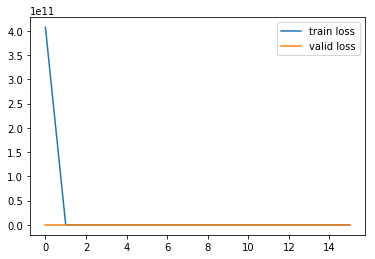

KeyError: ignored

In [96]:
# plot the error
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'valid loss')
plt.legend()
plt.show()

plt.plot(r.history['mean_squared_logarithmic_error'], label = 'train mse')
plt.plot(r.history['val_mean_squared_logarithmic_error'], label = 'valid mse')
plt.legend()
plt.show()

In [0]:
df['ke'] = pred_ke

## Evaluation

In [0]:
df.head()

,val,el,knn,svm,xg,cb,lg,ke
1801,16.039905,13.970003,15.484801,17.056366,14.196568,13.450701,13.599092,16.058355
1190,2.079442,13.372852,13.259560,15.267568,14.423588,14.884168,14.334657,16.058355
1817,10.425283,13.144124,14.496541,17.056366,12.929965,11.112633,12.468197,16.058355
251,16.119826,18.589274,18.654730,17.056366,18.480886,18.914405,18.736102,16.058355
2505,16.002777,12.334786,11.962382,13.012355,12.654006,12.484506,11.662387,16.058355


In [0]:
df.describe()

,val,el,knn,svm,xg,cb,lg,ke
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,16.143154,16.128647,16.081906,16.493079,16.082863,16.068532,16.119426,16.058489
std,2.935994,2.095988,2.058289,1.154391,2.363301,2.390009,2.348271,0.000134
min,1.098612,9.581723,10.869261,12.401184,5.446157,4.308870,6.781648,16.058355
25%,14.782020,14.512070,14.593794,17.056366,14.680010,14.669740,14.541517,16.058355
50%,16.860845,16.338209,16.452255,17.056366,16.505842,16.469731,16.501023,16.058355
75%,18.250752,17.560428,17.693591,17.056366,17.914801,17.911755,17.943879,16.058355
max,20.748437,22.462571,20.320846,17.418798,20.635166,20.884438,20.739231,16.058355


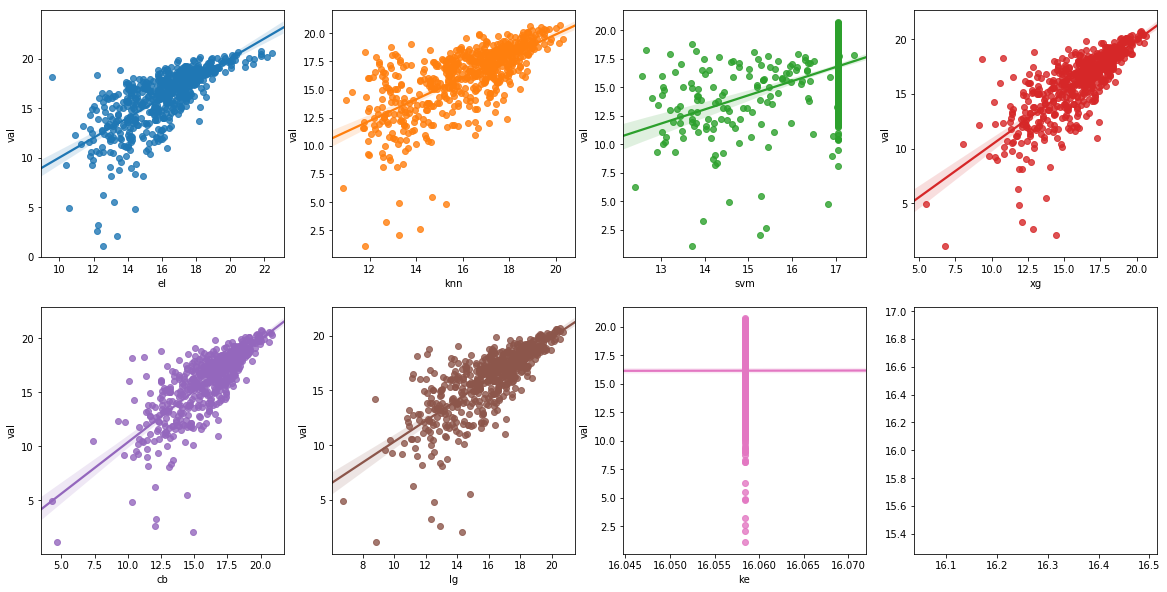

In [0]:
fig, axes = plt.subplots(2, 4, figsize = (20, 10))

for i, col in enumerate(df.columns[1:]):
  sns.regplot(x = col, y = 'val', data = df, ax = axes[i//4, i%4])

In [0]:
df.to_csv('pred.csv', index = False)

## Stacking

In [99]:
df.head()

,val,xg,cb,lg
1801,16.039905,13.936003,14.267066,13.990483
1190,2.079442,13.882005,14.553771,13.909740
1817,10.425283,12.062208,11.838425,12.372773
251,16.119826,17.016260,16.924673,17.427566
2505,16.002777,10.888381,11.815531,10.386738


In [0]:
y = df.val
stack_X_tr = df.loc[:, ['xg', 'cb', 'lg']]

In [101]:
y.shape

(600,)

In [102]:
from sklearn.linear_model import LinearRegression
model2_lr = LinearRegression()
model2_lr.fit(stack_X_tr, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [103]:
model2_lr.coef_

array([0.36722489, 0.54562263, 0.06340409])

In [104]:
from sklearn.svm import LinearSVR
model2_svm = LinearSVR(epsilon=1.)
model2_svm.fit(stack_X_tr, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=1.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [105]:
model2_svm.coef_

array([0.32842528, 0.48072061, 0.12816652])

In [106]:
from sklearn.ensemble import RandomForestRegressor
model2_rf = RandomForestRegressor(n_estimators = 100, max_depth = 3)
model2_rf.fit(stack_X_tr, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [107]:
model2_rf.feature_importances_

array([0.44086544, 0.36815274, 0.19098182])

In [0]:
coef_list = []
for i in range(3):
  coef = np.mean(model2_lr.coef_[i] + model2_svm.coef_[i] + model2_rf.feature_importances_[i])
  coef_list.append(coef)

In [0]:
coef_list = np.round(coef_list/sum(coef_list), 2)

In [110]:
coef_list

array([0.39, 0.48, 0.13])

In [0]:
df.head()

,val,el,knn,svm,xg,cb,lg,ke
1801,16.039905,13.970003,15.484801,17.056366,14.196568,13.450701,13.599092,16.058355
1190,2.079442,13.372852,13.259560,15.267568,14.423588,14.884168,14.334657,16.058355
1817,10.425283,13.144124,14.496541,17.056366,12.929965,11.112633,12.468197,16.058355
251,16.119826,18.589274,18.654730,17.056366,18.480886,18.914405,18.736102,16.058355
2505,16.002777,12.334786,11.962382,13.012355,12.654006,12.484506,11.662387,16.058355


## Submission

In [0]:
df_pred = pd.DataFrame()

In [0]:
df_pred['xg'] = model_xg.predict(te)
df_pred['cb'] = model_cb.predict(te)
df_pred['lg'] = model_lg.predict(te)

#df_pred['knn'] = model_knn.predict(te_el)
#df_pred['svm'] = model_svm.predict(te_el)

In [0]:
#df_pred['final'] = np.expm1(.2*df_pred.el + .5*df_pred.cb + .3*df_pred.xg)
#df_pred['final'] = np.expm1(.4*df_pred.cb + .4*df_pred.xg + .3*df_pred.lg)

In [0]:
#df_pred['final'] = np.expm1(df_pred.knn*.03 + df_pred.svm*.25 + df_pred.xg*.44 + df_pred.cb*.24 + df_pred.lg*.03)
df_pred['final'] = np.expm1(df_pred.knn*.03 + df_pred.svm*.03 + df_pred.xg*.44 + df_pred.cb*.24 + df_pred.lg*.25)

In [0]:
df_pred['final'] = np.expm1(.5*df_pred.xg + .5*df_pred.cb)

In [0]:
df_pred.head()

,xg,cb,lg,knn,svm,final
0,16.489323,15.952608,14.665325,13.046061,14.364026,1.050429e+07
1,14.384415,15.877779,13.287444,11.967845,17.056366,4.327209e+06
2,16.693792,15.839012,16.416958,14.622095,15.890669,1.064844e+07
3,15.670389,15.299456,15.372147,14.885672,17.056366,5.115720e+06
4,14.508597,13.855150,13.677596,15.317888,17.056366,1.351233e+06


In [123]:
sub = pd.read_csv('sample_submission.csv')
sub.shape

(4398, 2)

In [116]:
sub.head()

,id,revenue
0,3001,1000000
1,3002,1000000
2,3003,1000000
3,3004,1000000
4,3005,1000000


In [0]:
sub['revenue'] = df_pred.final

In [0]:
from google.colab import files

sub.to_csv('sub.csv', index = False)
files.download('sub.csv')

In [0]:
!kaggle competitions submit -c tmdb-box-office-prediction -f sub.csv -m "Message"

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 6, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 116, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
